In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Useful functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

#A function to load motor data and end-effector XYZ data:
def load_data(labels_file, inputs_file):

  # labels - positions of linear actuators
  # inputs - xyz coordinate
  file_path = f'/content/drive/MyDrive/ISSAI/Dataset_for_Tensegrity/{labels_file}.csv'
  labels = pd.read_csv(file_path)


  temp = pd.read_csv(f'/content/drive/MyDrive/ISSAI/Dataset_for_Tensegrity/{inputs_file}.csv')
  inputs = temp.iloc[4:, 2:5]
  inputs.drop(inputs.index[0], inplace=True)
  inputs.reset_index(drop=True, inplace=True)


  labels = labels.to_numpy()
  y_temp = inputs.to_numpy()
  inputs = y_temp.astype(float)

  return labels, inputs


#a function to match size and resolution of features and target data
def equalizer(features, target):

  features = features[::3].copy()
  features = pd.DataFrame(features)
  target = pd.DataFrame(target)

  X_len = len(features)
  Y_len = len(target)
  if X_len-Y_len>0:
    features = features[:Y_len]
  else:
    target = target[:X_len]
  return features, target

def removeNaN(arr):
  arr_copy = np.copy(arr)
  # Iterate through the array and replace NaN values
  for i in range(1, arr.shape[0]-1):
    for j in range(arr.shape[1]):
        if np.isnan(arr[i, j]):
            # Check if at least one of the neighboring values is not NaN
            if not (np.isnan(arr[i-1, j]) and np.isnan(arr[i+1, j])):
                # Calculate mean of neighboring values
                mean_value = np.nanmean([x for x in [arr[i-1, j], arr[i+1, j]] if not np.isnan(x)])
                arr_copy[i, j] = mean_value
  return arr
# arr_copy now contains the array with NaN values replaced by mean of neighboring values

def removeNaNIteratively(arr):
    # while np.isnan(arr).any():
    #     arr = removeNaN(arr)
    return arr


#Function to remove broken data
def find_sinusoid_boundaries(data, threshold1=0.0001, threshold2=0.01):
    """
    Finds the start and end indices of a sinusoid period
    """
    n = len(data)
    start_index, end_index = None, None
    consecutive_changes = 0

    for i in range(1, n):
      diff = abs(data[i] - data[i - 1])
      if diff > threshold1:
        start_index = i
        break
    if start_index:
      for j in range(start_index + 5000, n):
        if abs(data[j] - data[start_index]) < threshold2:
          end_index = j
          break

    return start_index, end_index

#Function to remove broken data
def find_xyz_boundaries(data, threshold1=0.003, threshold2=0.01):
    """
    Finds the start and end indices of a sinusoid period
    """
    n = len(data)
    start_index, end_index = None, None
    consecutive_changes = 0

    for i in range(1, n):
      diff = abs(data[i] - data[i - 1])
      if diff > threshold1:
        start_index = i
        break
    if start_index:
      for j in range(start_index + 400, n):
        if abs(data[j] - data[start_index]) < threshold2:
          end_index = j
          break

    return start_index, end_index


def plot_features_targets(features, targets):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot targets
    axes[0].plot(targets)
    axes[0].set_title('Targets')

    # Check if features is a DataFrame or NumPy array and index accordingly
    if isinstance(features, pd.DataFrame):
        axes[1].plot(features.iloc[:, 0])  # Use .iloc for pandas DataFrame
    elif isinstance(features, np.ndarray):
        #x_values = range(features.shape[0])
        axes[1].plot(features[:, 0])  # Use array indexing for NumPy array
    else:
        raise ValueError("features must be a pandas DataFrame or a NumPy array.")
    axes[1].set_title('Features')

    # Add labels and titles
    plt.xlabel('Time')
    plt.ylabel('Values')

    plt.tight_layout()
    plt.show()


def imputeData(data,n):
    for i in range(n):
      imputer = IterativeImputer(max_iter = i, random_state = 42, verbose=3)
      impute_data = imputer.fit_transform(data)
      impute_data = pd.DataFrame(impute_data, columns=data.columns)
      # print(i)
      # print(impute_data)
    return impute_data

# Data loading and trimming
---
We use plotting to observe and trim the data manually when needed


features, targets = load_data('optitrack_data_lr_tr', '23.07FirstTake')
plot_features_targets(features, targets)

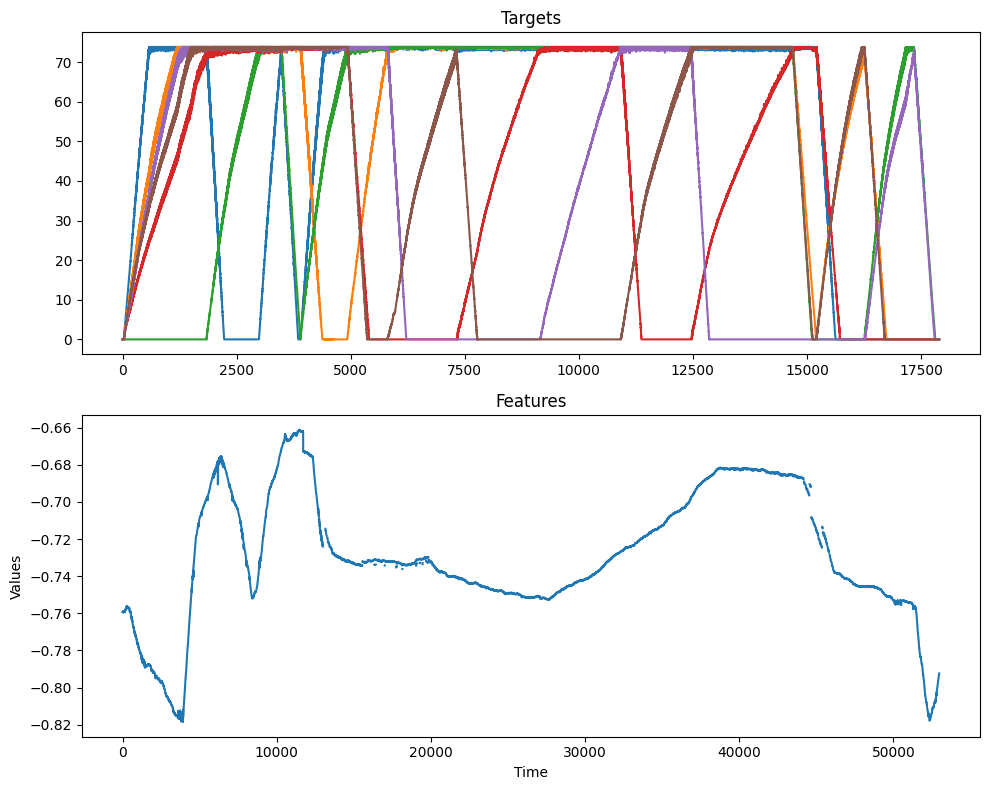

In [ ]:
targets, features = load_data('23.07FirstTake', 'optitrack_data_lr_tr')
plot_features_targets(features, targets)

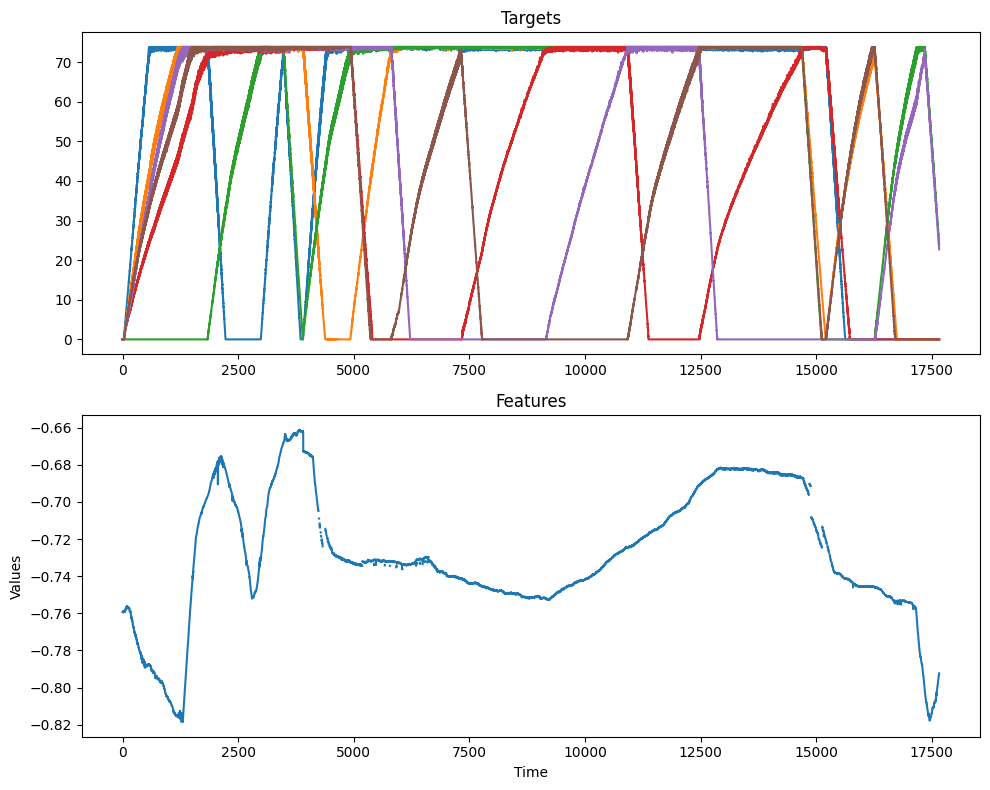

In [ ]:
features_equal, targets_equal = equalizer(features, targets)
plot_features_targets(features_equal, targets_equal)

In [ ]:
print(len(targets_equal))
print(len(features_equal))

17659
17659


In [ ]:
print(targets_equal)
print(features_equal)

              0         1         2
0     -0.759297  0.419074  0.740129
1     -0.759205  0.418863  0.740100
2     -0.759242  0.419042  0.740124
3     -0.759302  0.419248  0.740149
4     -0.759177  0.418970  0.740117
...         ...       ...       ...
17654 -0.792983  0.448643  0.749151
17655 -0.792826  0.448686  0.749581
17656 -0.792655  0.448561  0.749904
17657 -0.792503  0.448450  0.749926
17658 -0.792339  0.448455  0.750132

[17659 rows x 3 columns]


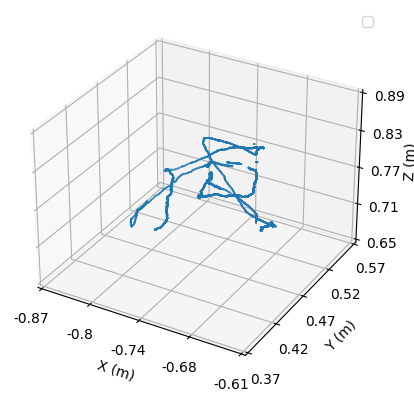

In [ ]:
from matplotlib.ticker import FormatStrFormatter

print(features_equal)
# make a 3d scatter plot of featuires_equal
# make a 3d scatter plot of featuires_equal
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Access the columns of the DataFrame using the iloc indexer
ax.scatter(features_equal.iloc[:, 0], features_equal.iloc[:, 1], features_equal.iloc[:, 2], s=0.1)

# Use features_equal instead of all_coords to set the axis limits
ax.set_xlim([features_equal.iloc[:, 0].min() - 0.05, features_equal.iloc[:, 0].max() + 0.05])
ax.set_ylim([features_equal.iloc[:, 1].min() - 0.05, features_equal.iloc[:, 1].max() + 0.05])
ax.set_zlim([features_equal.iloc[:, 2].min() - 0.05, features_equal.iloc[:, 2].max() + 0.05])

ax.set_xticks(np.linspace(features_equal.iloc[:, 0].min() - 0.05, features_equal.iloc[:, 0].max() + 0.05, 5))
ax.set_yticks(np.linspace(features_equal.iloc[:, 1].min() - 0.05, features_equal.iloc[:, 1].max() + 0.05, 5))
ax.set_zticks(np.linspace(features_equal.iloc[:, 2].min() - 0.05, features_equal.iloc[:, 2].max() + 0.05, 5))

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2g'))


# Labels and legend
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')

ax.zaxis.labelpad = 2
ax.legend()

# Adding the end-effector shift:

In [ ]:
# x_shift = 0
# y_shift = 0

In [ ]:
# features10_equal[2] = features10_equal[2] + y_shift
# features20_equal[2] = features20_equal[2] + y_shift
# features30_equal[2] = features30_equal[2] + y_shift
# features40_equal[2] = features40_equal[2] + y_shift
# features50_equal[2] = features50_equal[2] + y_shift
# features60_equal[2] = features60_equal[2] + y_shift

In [ ]:
# features10_equal[0] = features10_equal[0] + x_shift
# features20_equal[0] = features20_equal[0] + x_shift
# features30_equal[0] = features30_equal[0] + x_shift
# features40_equal[0] = features40_equal[0] + x_shift
# features50_equal[0] = features50_equal[0] + x_shift
# features60_equal[0] = features60_equal[0] + x_shift

## Spliting the data to training, validation and testing data

concatinating data

Check linear correlation

observing linearity

<Axes: >

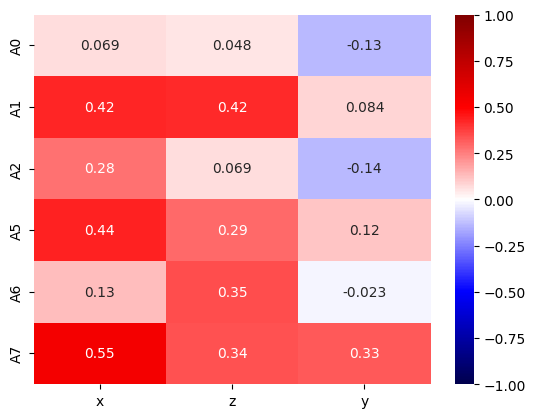

In [ ]:
import seaborn as sns
import pandas as pd

# Convert targets to a DataFrame
targets_df = pd.DataFrame(targets_equal)

# Convert features to a DataFrame if it's not already
features_df = pd.DataFrame(features_equal) # Wrap features in a DataFrame

# Set column names for features and targets
features_df.columns = ['x', 'z', 'y']  # Assuming features represent x, z, y
targets_df.columns = ['A0', 'A1', 'A2', 'A5', 'A6', 'A7']

# Select the columns
all_data = pd.concat([features_df, targets_df], axis=1) # Concatenate DataFrames
columns_first = all_data.columns[:3]
columns_last = all_data.columns[3:]

# Compute correlation matrix
correlations = all_data.corr()

# Filter the correlation matrix
corr_selected = correlations.loc[columns_last, columns_first]

# Create heatmap
sns.heatmap(corr_selected, vmin=-1, vmax=1, annot=True, cmap='seismic')

In [ ]:
all_data = all_data.dropna()
print(all_data)

              x         z         y   A0   A1     A2   A5     A6   A7
0     -0.759297  0.419074  0.740129  0.0  0.0   0.00  0.0   0.00  0.0
1     -0.759205  0.418863  0.740100  0.0  0.0   0.00  0.0   0.00  0.0
2     -0.759242  0.419042  0.740124  0.0  0.0   0.00  0.0   0.00  0.0
3     -0.759302  0.419248  0.740149  0.0  0.0   0.00  0.0   0.00  0.0
4     -0.759177  0.418970  0.740117  0.0  0.0   0.00  0.0   0.00  0.0
...         ...       ...       ...  ...  ...    ...  ...    ...  ...
17654 -0.792983  0.448643  0.749151  0.0  0.0  24.67  0.0  23.22  0.0
17655 -0.792826  0.448686  0.749581  0.0  0.0  24.52  0.0  23.22  0.0
17656 -0.792655  0.448561  0.749904  0.0  0.0  24.23  0.0  23.01  0.0
17657 -0.792503  0.448450  0.749926  0.0  0.0  24.31  0.0  23.01  0.0
17658 -0.792339  0.448455  0.750132  0.0  0.0  24.02  0.0  22.72  0.0

[10708 rows x 9 columns]


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'all_data' is a Pandas DataFrame or a NumPy array
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

# You can adjust 'test_size' to control the split ratio
# 'random_state' ensures reproducibility of the split

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (8566, 9)
Test data shape: (2142, 9)


In [ ]:
all_data.describe()

x             z             y            A0            A1  \
count  10708.000000  10708.000000  10708.000000  10708.000000  10708.000000   
mean      -0.731434      0.489925      0.768493     48.170518     56.017208   
std        0.039165      0.016020      0.033297     31.977929     26.897809   
min       -0.818587      0.418863      0.700509      0.000000      0.000000   
25%       -0.751481      0.480564      0.742528      5.462500     41.480000   
50%       -0.733554      0.493441      0.764330     73.150000     73.290000   
75%       -0.696963      0.501193      0.790448     73.800000     73.800000   
max       -0.661132      0.522072      0.843932     73.800000     73.800000   

                 A2            A5            A6            A7  
count  10708.000000  10708.000000  10708.000000  10708.000000  
mean      46.526152     40.113430     43.131093     42.814719  
std       30.977417     31.254249     31.474154     30.992233  
min        0.000000      0.000000      0.000000      0.000000  
25%        9.370000      0.000000      0.000000      2.862500  
50%       64.630000     45.800000     54.750000     52.300000  
75%       73.650000     73.150000     73.430000     73.650000  
max       73.800000     73.800000     73.800000     73.800000

In [ ]:
all_data

x         z         y   A0   A1     A2   A5     A6   A7
0     -0.759297  0.419074  0.740129  0.0  0.0   0.00  0.0   0.00  0.0
1     -0.759205  0.418863  0.740100  0.0  0.0   0.00  0.0   0.00  0.0
2     -0.759242  0.419042  0.740124  0.0  0.0   0.00  0.0   0.00  0.0
3     -0.759302  0.419248  0.740149  0.0  0.0   0.00  0.0   0.00  0.0
4     -0.759177  0.418970  0.740117  0.0  0.0   0.00  0.0   0.00  0.0
...         ...       ...       ...  ...  ...    ...  ...    ...  ...
17654 -0.792983  0.448643  0.749151  0.0  0.0  24.67  0.0  23.22  0.0
17655 -0.792826  0.448686  0.749581  0.0  0.0  24.52  0.0  23.22  0.0
17656 -0.792655  0.448561  0.749904  0.0  0.0  24.23  0.0  23.01  0.0
17657 -0.792503  0.448450  0.749926  0.0  0.0  24.31  0.0  23.01  0.0
17658 -0.792339  0.448455  0.750132  0.0  0.0  24.02  0.0  22.72  0.0

[10708 rows x 9 columns]

In [ ]:
X_train = train_data[['x','z','y']]
##### change for your motors
y_train = train_data[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']]

X_test = test_data[['x','z', 'y']]
y_test = test_data[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']]

print(type(X_train))
print(y_train)

print(X_test)
print(y_test)

<class 'pandas.core.frame.DataFrame'>
          A0     A1     A2     A5     A6     A7
2520    0.00  73.80  51.43  73.80  73.80  73.80
3471   71.49  73.00  73.43  73.07  73.36  73.29
16890   0.00   0.00  57.92   0.00  48.98   0.00
16771   0.00   0.00  50.20   0.00  42.70   0.00
16845   0.00   0.00  55.18   0.00  46.89   0.00
...      ...    ...    ...    ...    ...    ...
7836   73.22  73.58  73.58  25.68   0.00   0.00
6560   73.80  73.80  73.51   0.00   0.00  42.77
7023   73.72  73.80  73.80   0.00   0.00  62.54
860    73.80  57.85   0.00  34.77  53.16  46.09
11448  73.80  73.80  73.58   0.00  73.29  34.41

[8566 rows x 6 columns]
              x         z         y
2886  -0.747849  0.499730  0.798014
3937  -0.673046  0.479185  0.736468
304   -0.774164  0.458707  0.737659
3329  -0.682828  0.504164  0.713001
2630  -0.724297  0.502793  0.826979
...         ...       ...       ...
16358 -0.746883  0.496510  0.787626
17193 -0.769392  0.498385  0.770585
1103  -0.812745  0.509378  0.747976
1

Application of StandardScaler

In [ ]:
# 2. Применяем StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# Преобразуем обратно в DataFrame для удобства анализа
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = ['X', 'Z', 'Y'])
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns = ['A0', 'A1', 'A2', 'A5', 'A6', 'A7'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = ['X', 'Z', 'Y'])
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns = ['A0', 'A1', 'A2', 'A5', 'A6', 'A7'])



In [ ]:
# StandardScaler makes dispersion var to be equal to 1. Let's check dispersion of the inputs before applying scaler:
from sklearn.preprocessing import StandardScaler

print("Mean before standartization:")
print(X_train.mean())

print("\nDispersion before standartization:")
print(X_train.var())

# 2. Применяем StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

# Преобразуем обратно в DataFrame для удобства анализа
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = ['X', 'Z', 'Y'])
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns = ['A0', 'A1', 'A2', 'A5', 'A6', 'A7'])

# 3. Проверяем среднее и дисперсию после стандартизации
print("\nMean after standartization:")
print(X_train_scaled_df.mean())

print("\nDispersion after standartization:")
print(X_train_scaled_df.var())


Mean before standartization:
x   -0.731356
z    0.490011
y    0.768690
dtype: float64

Dispersion before standartization:
x    0.001540
z    0.000256
y    0.001114
dtype: float64

Mean after standartization:
X   -1.327965e-15
Z    7.071418e-16
Y    2.028937e-15
dtype: float64

Dispersion after standartization:
X    1.000117
Z    1.000117
Y    1.000117
dtype: float64


In [ ]:
'''
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = x_scaler.fit_transform(X_train)'''

EDA. Analyzing distribution.

1. Distribution Analysis:
Why? Understanding the distribution of both your input features (coordinates) and target variables (motor values) can reveal potential skewness, outliers, or non-normal distributions, which could affect model performance.

What to do? Create histograms or Kernel Density Estimation (KDE) plots to visualize the distribution of the coordinate features and actuator values.

Insight: If any of the features are heavily skewed, applying transformations (e.g., log transformation) might be beneficial before modeling.

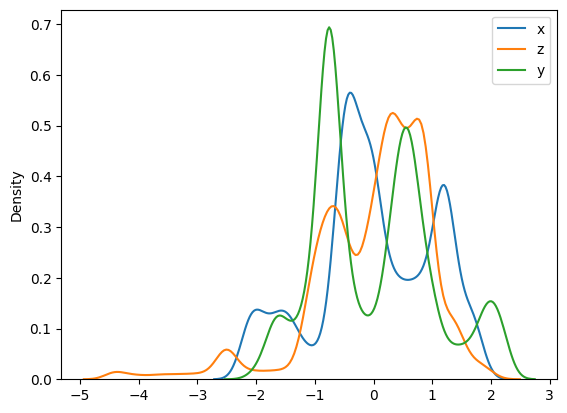

In [ ]:
# KDE plot after StandardScaler что показывает улучшение распределения данных
sns.kdeplot(X_train_scaled[:, 0], label='x') # Access the first column of the NumPy array (index 0)
sns.kdeplot(X_train_scaled[:, 1], label='z') # Access the second column of the NumPy array (index 1)
sns.kdeplot(X_train_scaled[:, 2], label='y')

plt.legend()
plt.show()


<Axes: xlabel='A0', ylabel='Density'>

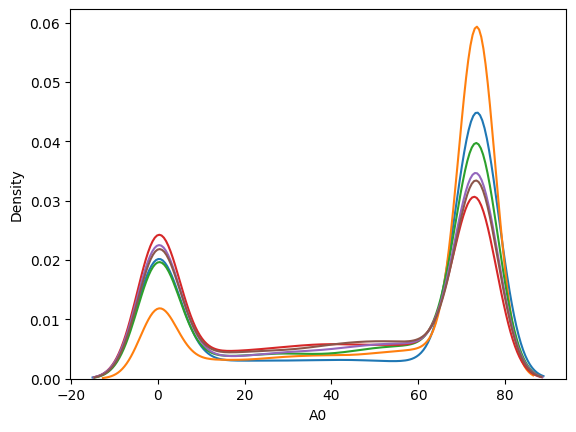

In [ ]:
sns.kdeplot(all_data['A0'], label='A0')
sns.kdeplot(all_data['A1'], label='A1')
sns.kdeplot(all_data['A2'], label='A2')
sns.kdeplot(all_data['A5'], label='A5')
sns.kdeplot(all_data['A6'], label='A6')
sns.kdeplot(all_data['A7'], label='A7')

<Axes: ylabel='Density'>

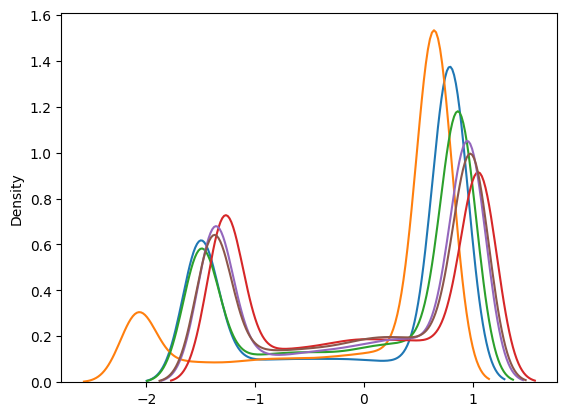

In [ ]:
sns.kdeplot(y_train_scaled[:, 0], label='A0')
sns.kdeplot(y_train_scaled[:, 1], label='A1')
sns.kdeplot(y_train_scaled[:, 2], label='A2')
sns.kdeplot(y_train_scaled[:, 3], label='A5')
sns.kdeplot(y_train_scaled[:, 4], label='A6')
sns.kdeplot(y_train_scaled[:, 5], label='A7')

2. Pairplot or Scatter Matrix:
Why? This helps visualize the relationships between all pairs of variables. It’s particularly useful to understand the linear or non-linear relationships between the input features and target variables.
What to do? Generate a pairplot or scatter matrix of the features and target variables to identify patterns or correlations that may not be obvious from individual plots.
Insight: This can help you identify multi-collinearity or non-linear relationships, which could inform model selection or the need for feature engineering.

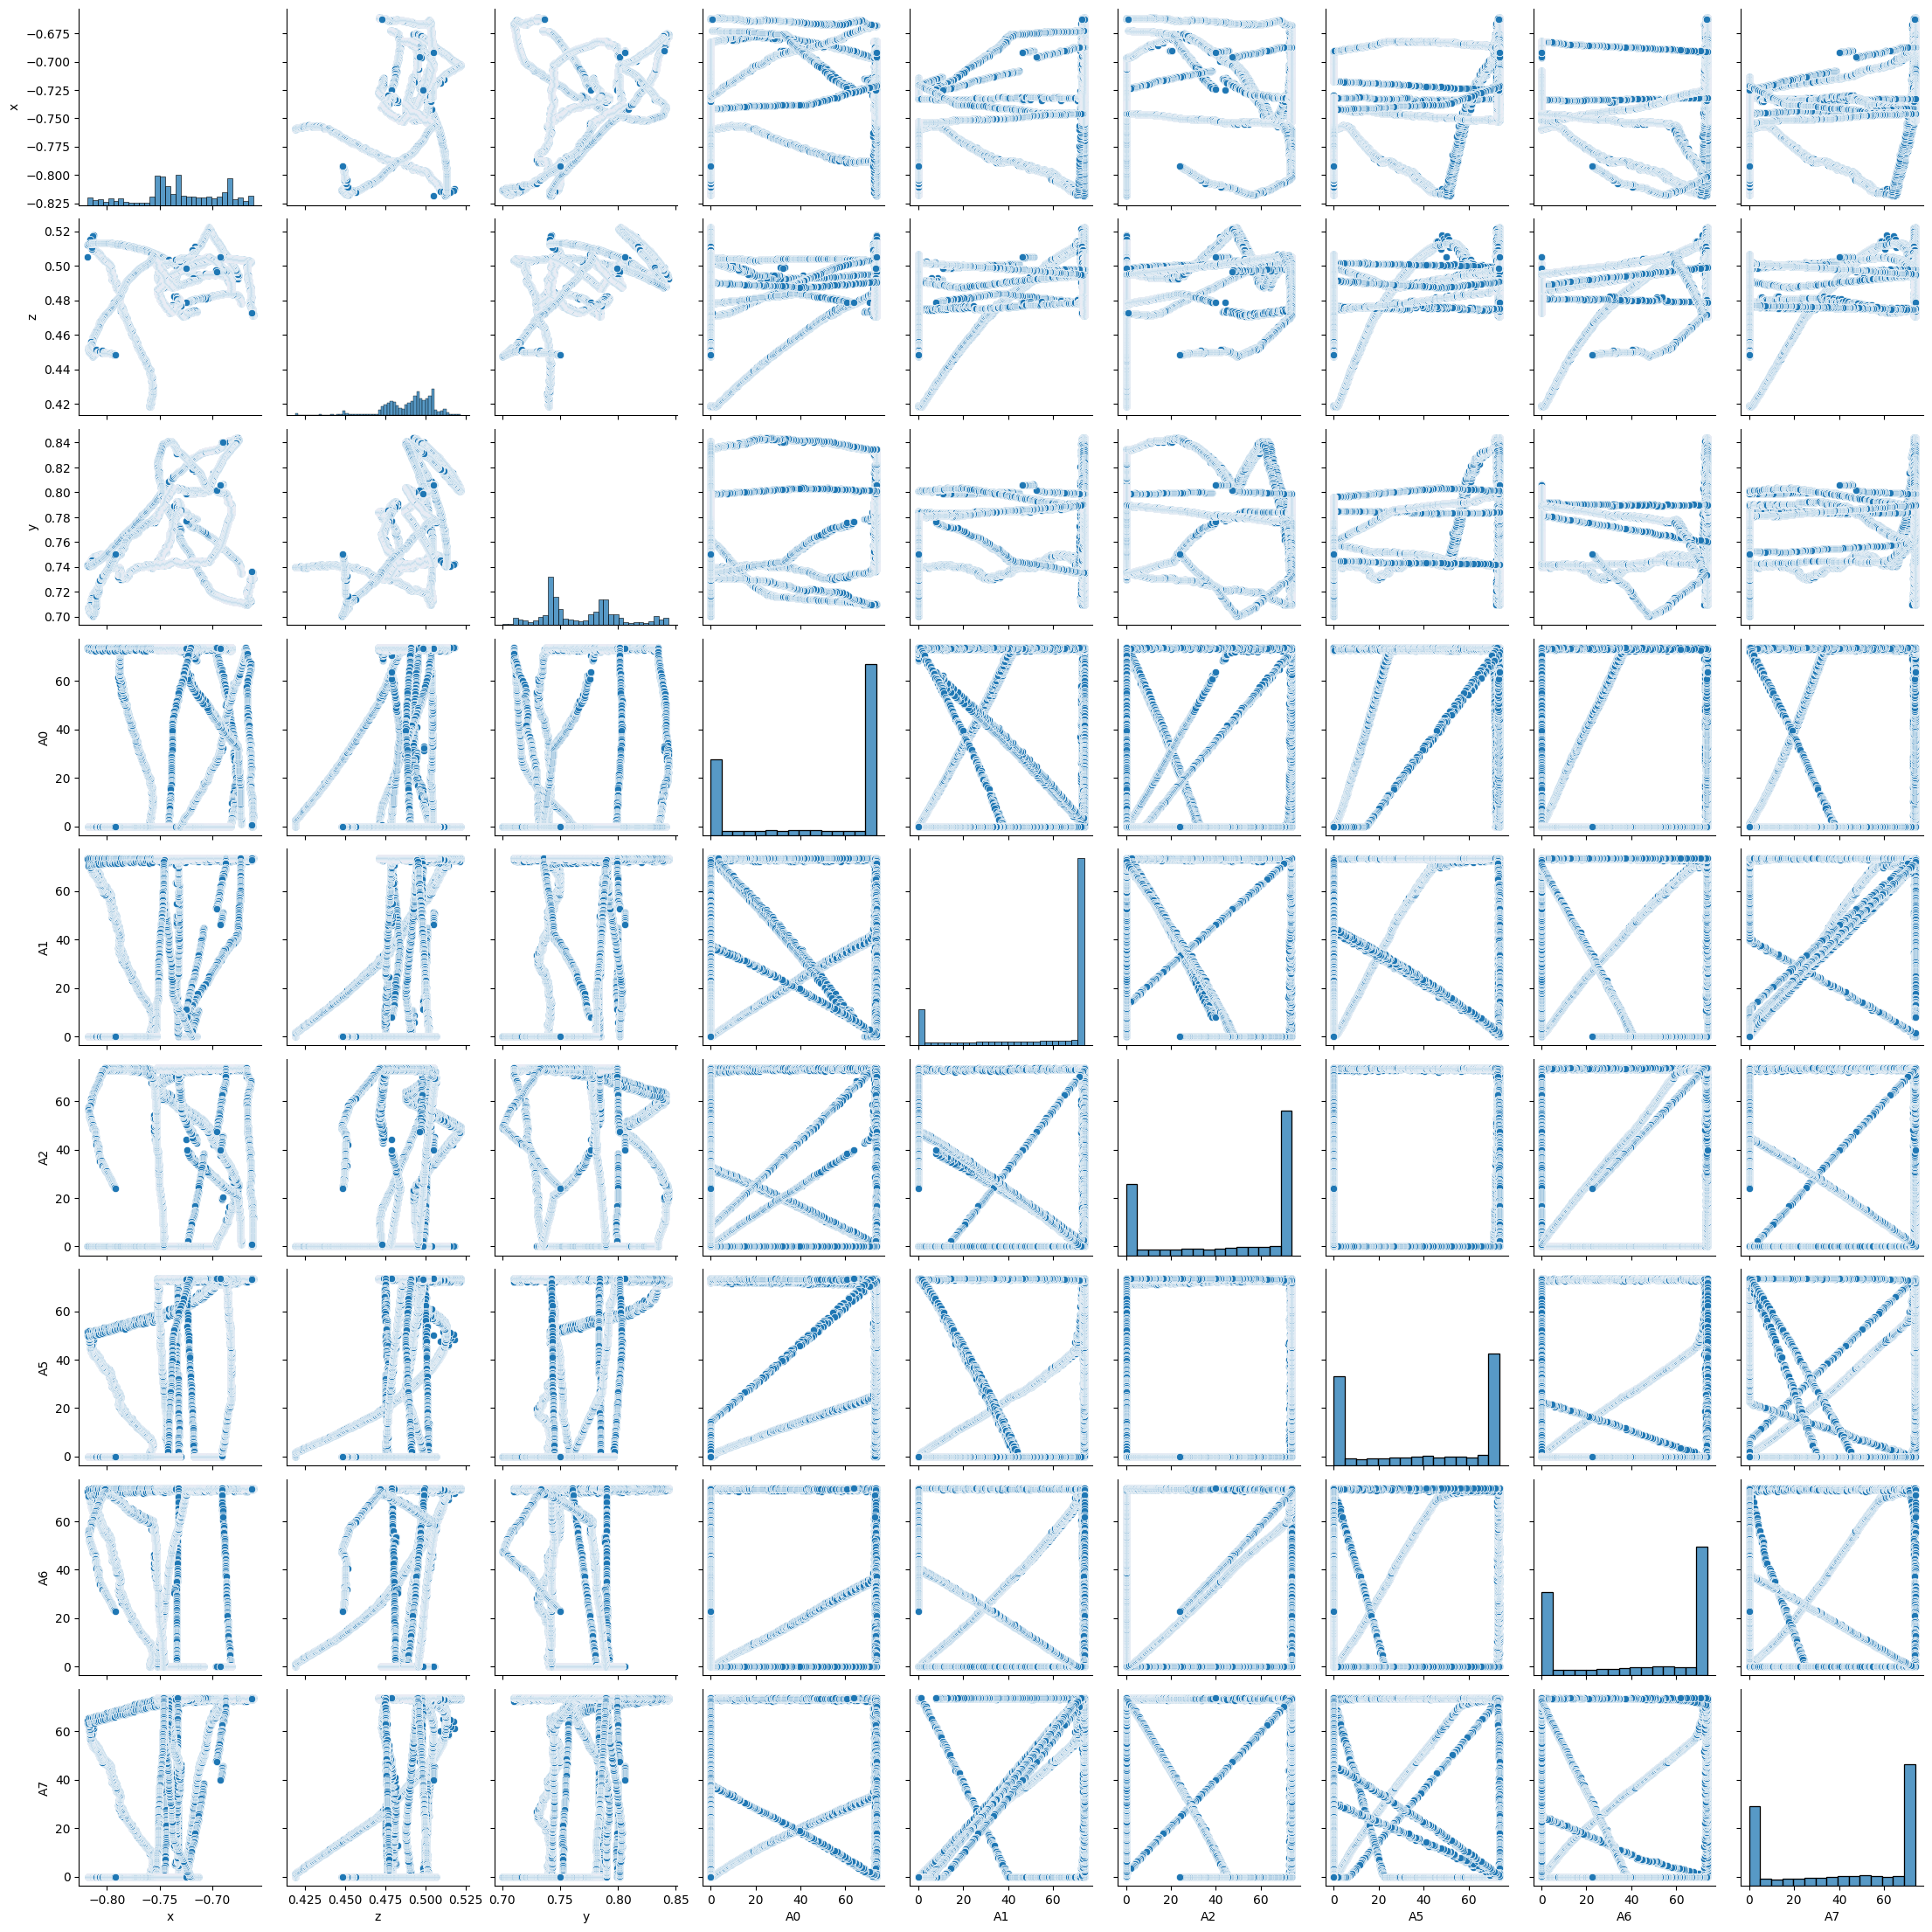

In [ ]:
# Pairplot to visualize relationships between all input features and target variables
sns.pairplot(all_data[['x', 'z', 'y', 'A0', 'A1', 'A2', 'A5', 'A6', 'A7']])
plt.show()


Analysis of Pairplot for Features (x, z, y) and Targets (A0, A1, A2, A5, A6, A7):
Absence of Strong Linear Relationships:

Across the scatter plots between the features (x, z, y) and the targets (A0, A1, A2, A5, A6, A7), there are no strong linear patterns visible. This suggests that the relationships between the input coordinates and the actuator values are more non-linear or complex. The scattered points do not form straight lines, indicating weak to moderate correlations.
Non-linear and Complex Patterns:

The scatter plots exhibit twisted and curved patterns between some of the features and target variables. These non-linear relationships indicate that simple linear models might struggle to capture the true dynamics of how the coordinates influence the actuators. This suggests that more advanced models (e.g., neural networks, random forests) that can handle non-linearities would be more suitable for the task.
Feature Distributions:

The diagonal histograms show the distribution of each feature and target:
The features x, z, and y have distinct ranges, with x skewed to the left and y and z skewed to the right.
The target variables A0 to A7 have a much wider range of values, with several peaks in distributions, especially for A0, A2, and A5. These peaks may indicate the existence of distinct modes of operation or different actuator behaviors under certain conditions.
Possible Correlations Between Actuators:

Some of the target variables (actuators), such as A1, A6, and A7, exhibit linear-like relationships with each other. This suggests that these actuators may be working in a coordinated manner, which could indicate multicollinearity between certain actuator values. These correlations may need to be handled using regularization techniques or dimensionality reduction if they interfere with model performance.
Outliers and Variability:

Several outliers are noticeable in the scatter plots, particularly in the relationships between x and certain actuators (e.g., A1, A2). These outliers may represent specific edge cases or anomalies in the data that could affect model performance if not handled properly.
No Clear Separation in Values:

The features x, z, and y show little clear separation when compared to the target variables. The actuator values span a wide range for all features, and there doesn’t seem to be a clear pattern that would suggest a simple relationship between any of the coordinates and the actuators.
Conclusion:
Complex, Non-linear Relationships: The pairplot suggests that the relationships between the features (coordinates) and targets (actuator values) are complex and non-linear. Models that can handle non-linearities, such as neural networks or random forests, might be more appropriate.
Multicollinearity Among Actuators: Some actuators (A1, A6, A7) seem to be correlated with each other, potentially requiring regularization techniques to avoid multicollinearity issues.
Outliers and Data Variability: The presence of outliers indicates that further attention may be needed to ensure robust model performance. Handling outliers and improving the variety of trajectories could help the model generalize better.
This analysis indicates the need for non-linear models and regularization techniques to capture the true relationships between the coordinates and actuators.

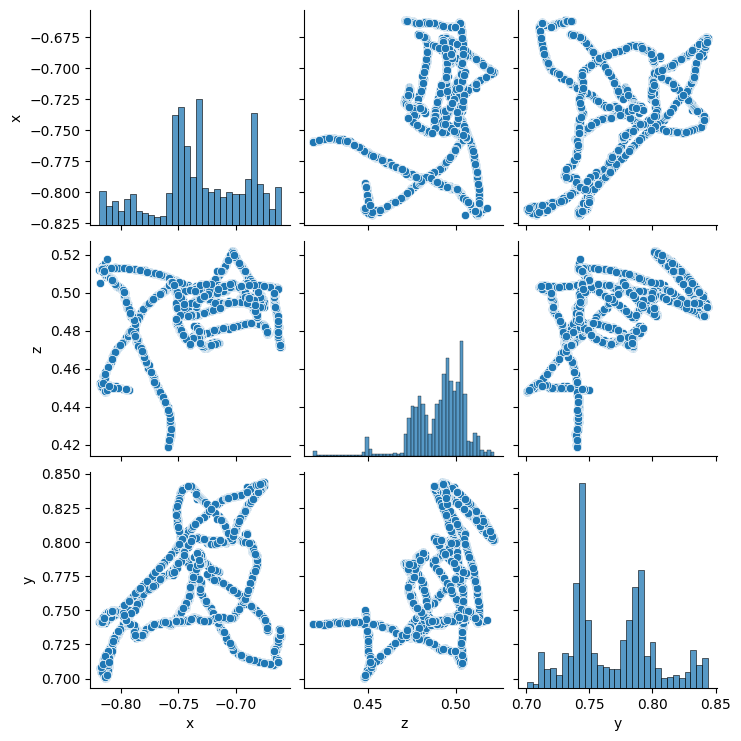

In [ ]:
# Pairplot to visualize relationships between all input features and target variables
sns.pairplot(X_train[['x', 'z', 'y']])
plt.show()


## Validation

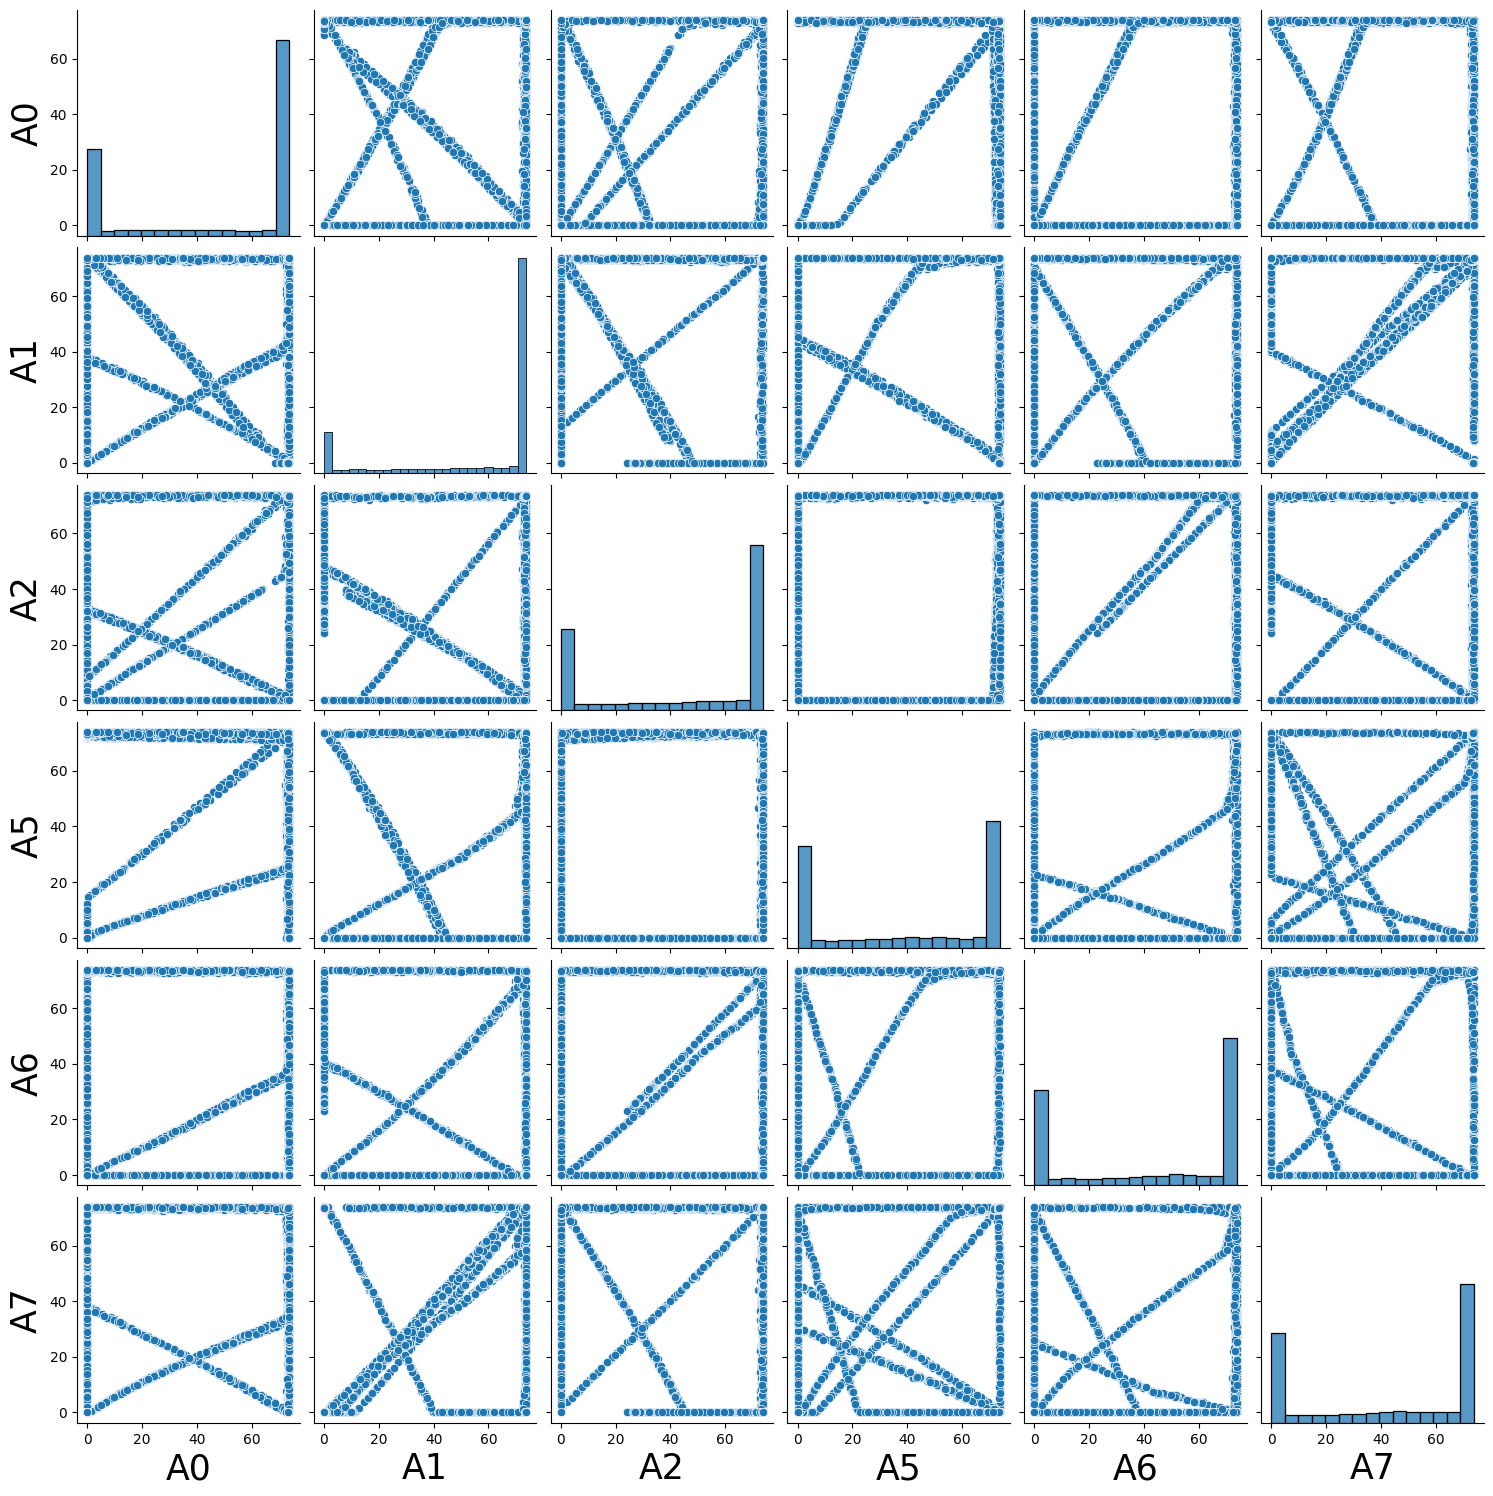

In [ ]:
pairplot = sns.pairplot(y_train[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']])
# Modify font size of axis labels
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=25)  # Adjust fontsize as needed
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)  # Adjust fontsize as needed
plt.show()

Multicollinearity Check (Variance Inflation Factor, VIF):
Why? Although regularization helps with reducing multicollinearity, it is still useful to know if certain features (coordinates or motor values) are highly correlated with one another, as this can lead to overfitting or misleading results.
What to do? Use Variance Inflation Factor (VIF) to check for multicollinearity between the features.
Insight: If VIF values are too high for some features, consider removing or combining them to improve model stability.

In [ ]:
!pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_data['feature'] = X_train.columns
print(vif_data)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 15.5 MB/s eta 0:00:00
  feature         VIF
0       x  219.855406
1       z  586.264897
2       y  454.560899


Результаты VIF (Variance Inflation Factor — фактор инфляции дисперсии) помогают оценить уровень мультиколлинеарности между признаками. Вот как можно интерпретировать результаты:

VIF = 1: Отсутствие мультиколлинеарности. Признаки никак не связаны друг с другом.
1 < VIF < 5: Умеренная мультиколлинеарность. Это уровень, который обычно приемлем, так как признаки не сильно зависят друг от друга.
VIF > 5: Высокая мультиколлинеарность. Это может указывать на сильную корреляцию между признаками, и в некоторых случаях стоит рассмотреть удаление или преобразование этих признаков.

У нас высокая мультиколлинеарность признаков до стандартизации


In [ ]:
vif_data_scaled = pd.DataFrame()
# Convert X_train_scaled to DataFrame. Preserves column names if X_train_scaled was a result of a DataFrame operation
vif_data_scaled["feature"] = pd.DataFrame(X_train_scaled).columns

# Calculate VIF for each feature
vif_data_scaled["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
print(vif_data_scaled)

   feature       VIF
0        0  1.099470
1        1  1.088713
2        2  1.124252


после стандартизации VIF в пределах нормы

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data_y= pd.DataFrame()
vif_data_y["feature"] = y_train.columns

# Calculate VIF for each feature
vif_data_y["VIF"] = [variance_inflation_factor(y_train.values, i) for i in range(y_train.shape[1])]
vif_data_y['feature'] = y_train.columns
print(vif_data_y)

  feature       VIF
0      A0  4.003728
1      A1  8.788634
2      A2  3.228387
3      A5  3.617256
4      A6  2.958609
5      A7  4.405689


In [ ]:
vif_data_scaled_y = pd.DataFrame()
# Convert X_train_scaled to DataFrame. Preserves column names if X_train_scaled was a result of a DataFrame operation
vif_data_scaled_y["feature"] = pd.DataFrame(y_train_scaled).columns

# Calculate VIF for each feature
vif_data_scaled_y["VIF"] = [variance_inflation_factor(y_train_scaled, i) for i in range(y_train_scaled.shape[1])]
print(vif_data_scaled_y)

   feature       VIF
0        0  1.323640
1        1  1.755543
2        2  1.163720
3        3  1.367097
4        4  1.219751
5        5  1.564299


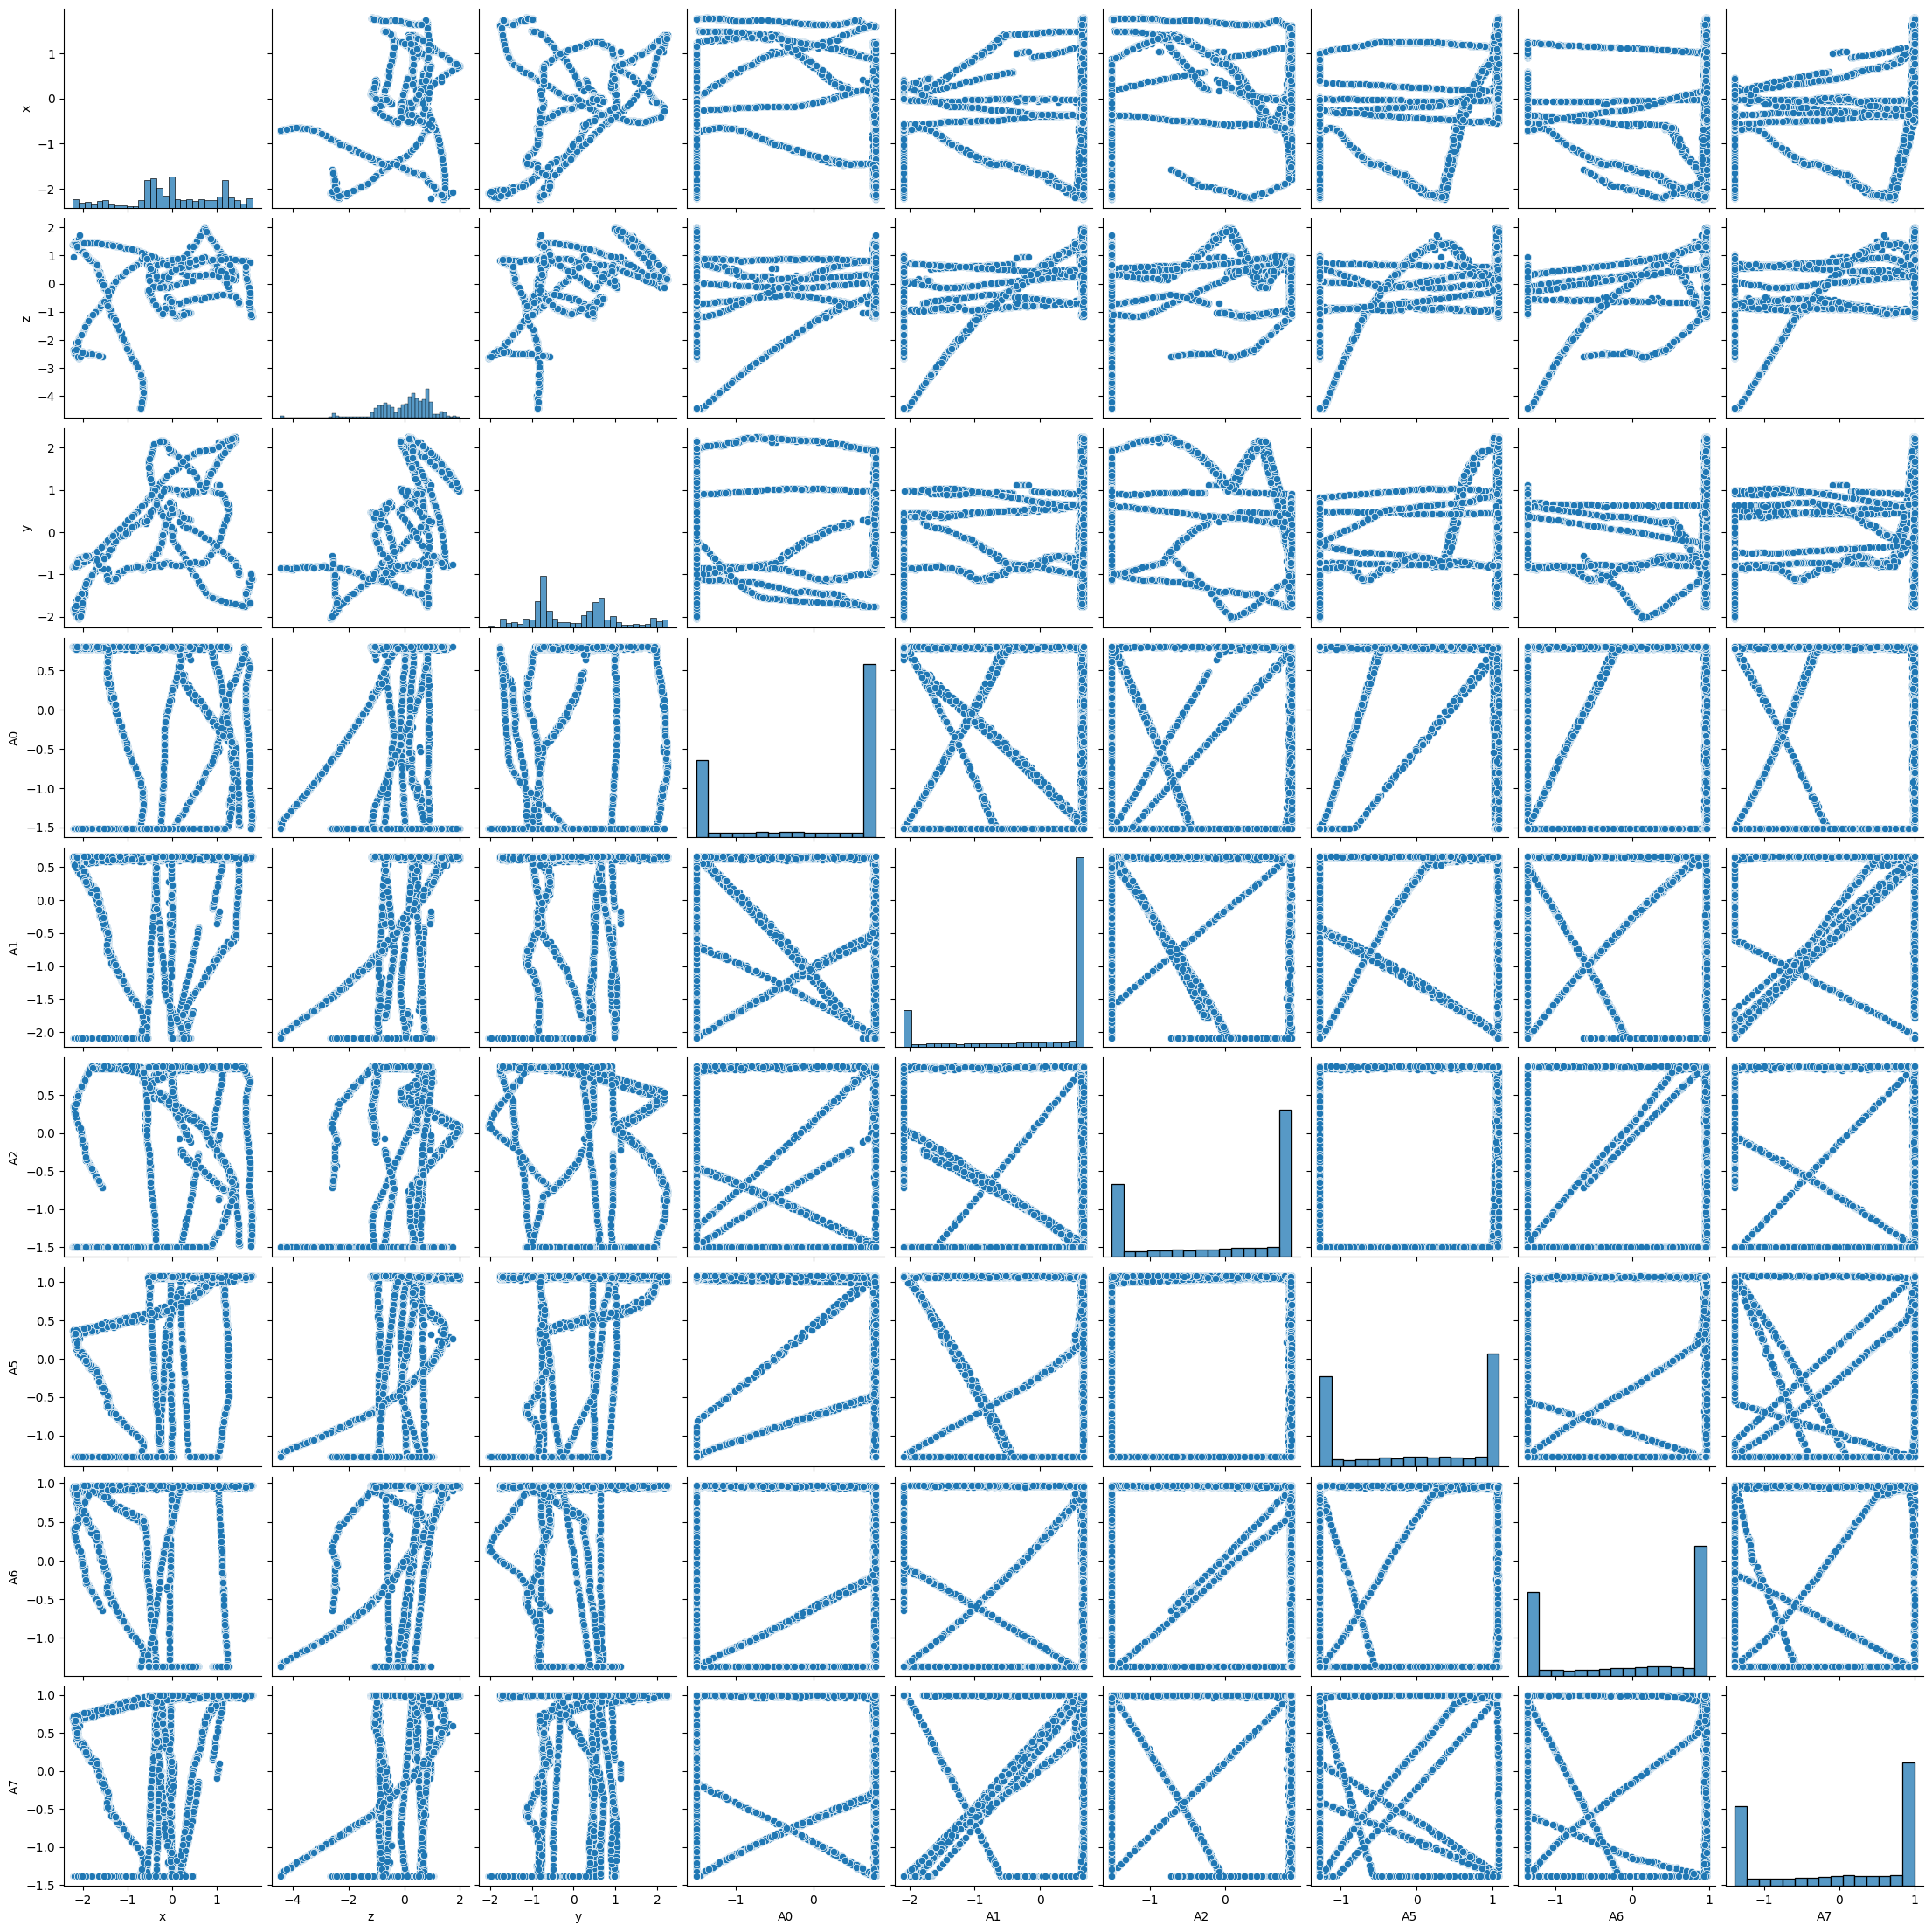

In [ ]:
combined_data = pd.concat([pd.DataFrame(X_train_scaled, columns=['x', 'z', 'y']), pd.DataFrame(y_train_scaled, columns=['A0', 'A1', 'A2', 'A5', 'A6', 'A7'])], axis=1)

# Now plot the pairplot on the combined data
sns.pairplot(combined_data)
plt.show()

после стандартизации VIF для таргета тоже стал в пределах нормы

Testing models section:

In [ ]:
#Medet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

# Create an RMSE scorer for GridSearchCV
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Dictionary to store the best results
best_results = {}

# 1. Ridge Regression: Tuning alpha (regularization strength)
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), param_grid=ridge_params, scoring=rmse_scorer, cv=5)
ridge_grid.fit(X_train_scaled, y_train_scaled)
print("Best Ridge Parameters:", ridge_grid.best_params_)
best_results['Ridge'] = ridge_grid.best_params_

# 2. Lasso Regression: Tuning alpha
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_params, scoring=rmse_scorer, cv=5)
lasso_grid.fit(X_train_scaled, y_train_scaled)
print("Best Lasso Parameters:", lasso_grid.best_params_)
best_results['Lasso'] = lasso_grid.best_params_

# 3. ElasticNet: Tuning alpha and l1_ratio
elastic_params = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.2, 0.5, 0.8]
}
elastic_grid = GridSearchCV(ElasticNet(), param_grid=elastic_params, scoring=rmse_scorer, cv=5)
elastic_grid.fit(X_train_scaled, y_train_scaled)
print("Best ElasticNet Parameters:", elastic_grid.best_params_)
best_results['ElasticNet'] = elastic_grid.best_params_

# # 4. Polynomial Regression: Tuning degree of polynomial
# poly_params = {'poly__degree': [2, 3, 4]}
# poly_model = Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression())])
# poly_grid = GridSearchCV(poly_model, param_grid=poly_params, scoring=rmse_scorer, cv=5)
# poly_grid.fit(X_train, y_train)
# print("Best Polynomial Degree:", poly_grid.best_params_)
# best_results['Polynomial'] = poly_grid.best_params_

# # 5. Support Vector Regression (SVR): Tuning kernel and C
# svr_params = {
#     'kernel': ['linear', 'rbf', 'poly'],
#     'C': [0.1, 1, 10],
#     'degree': [2, 3, 4]  # Only applies to the 'poly' kernel
# }
# svr_grid = GridSearchCV(SVR(), param_grid=svr_params, scoring=rmse_scorer, cv=5)
# svr_grid.fit(X_train, y_train)
# print("Best SVR Parameters:", svr_grid.best_params_)
# best_results['SVR'] = svr_grid.best_params_

# Summary of best hyperparameters
print("\nBest Hyperparameters from GridSearchCV:")
for model_name, params in best_results.items():
    print(f"{model_name}: {params}")


Best Ridge Parameters: {'alpha': 100}
Best Lasso Parameters: {'alpha': 1}
Best ElasticNet Parameters: {'alpha': 1, 'l1_ratio': 0.8}

Best Hyperparameters from GridSearchCV:
Ridge: {'alpha': 100}
Lasso: {'alpha': 1}
ElasticNet: {'alpha': 1, 'l1_ratio': 0.8}


In [ ]:
#Medet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Create an RMSE scorer for GridSearchCV
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Function to print all results
def print_results(grid_search):
    means_rmse = grid_search.cv_results_['mean_test_score']
    stds_rmse = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']

    for mean_rmse, std_rmse, param in zip(means_rmse, stds_rmse, params):
        print(f"Params: {param} -> RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})")

# Dictionary to store the best results
best_results = {}

# 1. Ridge Regression: Tuning alpha (regularization strength)
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), param_grid=ridge_params, scoring=rmse_scorer, cv=5, return_train_score=True)
ridge_grid.fit(X_train_scaled, y_train_scaled)
print("\nRidge Regression Results:")
print_results(ridge_grid)
best_results['Ridge'] = ridge_grid.best_params_

# 2. Lasso Regression: Tuning alpha
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_params, scoring=rmse_scorer, cv=5, return_train_score=True)
lasso_grid.fit(X_train_scaled, y_train_scaled)
print("\nLasso Regression Results:")
print_results(lasso_grid)
best_results['Lasso'] = lasso_grid.best_params_

# 3. ElasticNet: Tuning alpha and l1_ratio
elastic_params = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.2, 0.5, 0.8]
}
elastic_grid = GridSearchCV(ElasticNet(), param_grid=elastic_params, scoring=rmse_scorer, cv=5, return_train_score=True)
elastic_grid.fit(X_train_scaled, y_train_scaled)
print("\nElasticNet Results:")
print_results(elastic_grid)
best_results['ElasticNet'] = elastic_grid.best_params_

# 4. Polynomial Regression: Tuning degree of polynomial
poly_params = {'poly__degree': [2, 3, 4]}
poly_model = Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression())])
poly_grid = GridSearchCV(poly_model, param_grid=poly_params, scoring=rmse_scorer, cv=5, return_train_score=True)
poly_grid.fit(X_train_scaled, y_train_scaled)
print("\nPolynomial Regression Results:")
print_results(poly_grid)
best_results['Polynomial'] = poly_grid.best_params_

# # 5. Support Vector Regression (SVR): Tuning kernel and C
# svr_params = {
#     'kernel': ['linear', 'rbf', 'poly'],
#     'C': [0.1, 1, 10],
#     'degree': [2, 3, 4]  # Only applies to the 'poly' kernel
# }
# svr_grid = GridSearchCV(SVR(), param_grid=svr_params, scoring=rmse_scorer, cv=5, return_train_score=True)
# svr_grid.fit(X_train, y_train)
# print("\nSupport Vector Regression Results:")
# print_results(svr_grid)
# best_results['SVR'] = svr_grid.best_params_

# Summary of best hyperparameters
print("\nBest Hyperparameters from GridSearchCV:")
for model_name, params in best_results.items():
    print(f"{model_name}: {params}")



Ridge Regression Results:
Params: {'alpha': 0.1} -> RMSE: 0.8914 (+/- 0.0041)
Params: {'alpha': 1} -> RMSE: 0.8914 (+/- 0.0041)
Params: {'alpha': 10} -> RMSE: 0.8914 (+/- 0.0041)
Params: {'alpha': 100} -> RMSE: 0.8914 (+/- 0.0041)

Lasso Regression Results:
Params: {'alpha': 0.01} -> RMSE: 0.8916 (+/- 0.0041)
Params: {'alpha': 0.1} -> RMSE: 0.9055 (+/- 0.0036)
Params: {'alpha': 1} -> RMSE: 1.0001 (+/- 0.0035)
Params: {'alpha': 10} -> RMSE: 1.0001 (+/- 0.0035)

ElasticNet Results:
Params: {'alpha': 0.1, 'l1_ratio': 0.2} -> RMSE: 0.8938 (+/- 0.0039)
Params: {'alpha': 0.1, 'l1_ratio': 0.5} -> RMSE: 0.8975 (+/- 0.0038)
Params: {'alpha': 0.1, 'l1_ratio': 0.8} -> RMSE: 0.9025 (+/- 0.0037)
Params: {'alpha': 1, 'l1_ratio': 0.2} -> RMSE: 0.9526 (+/- 0.0032)
Params: {'alpha': 1, 'l1_ratio': 0.5} -> RMSE: 0.9975 (+/- 0.0036)
Params: {'alpha': 1, 'l1_ratio': 0.8} -> RMSE: 1.0001 (+/- 0.0035)
Params: {'alpha': 10, 'l1_ratio': 0.2} -> RMSE: 1.0001 (+/- 0.0035)
Params: {'alpha': 10, 'l1_ratio': 0.5}

In [ ]:
# Polynomial regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
def train_lin_poly_regressors(data, target, degree=1):
    """    Trains a polynomial regression model to predict multi-output targets.
        Parameters:
    - data: pd.DataFrame, the input data with features (6 columns for linear actuators).    - target: pd.DataFrame, the target data with 3 columns (X, Y, Z coordinates).
    - degree: int, the degree of the polynomial features to generate.
    Returns:    - model: A trained MultiOutputRegressor model that can predict the 3 coordinates.
    """    # Create a pipeline that first creates polynomial features, then applies linear regression
    pipeline = Pipeline([        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear_regression', LinearRegression())    ])
        # Use MultiOutputRegressor to handle the multi-target regression (predicting X, Y, Z simultaneously)
    model = MultiOutputRegressor(pipeline)
    # Fit the model using all the features (all 6 linear actuators)    model.fit(data, target)
    return model
# Example usage:
# Assuming train_data is your 6-column DataFrame with linear actuator data# and target_data is your 3-column DataFrame with X, Y, Z coordinates
# model = train_lin_poly_regressors(train_data, target_data, degree=2)

In [ ]:
model = train_lin_poly_regressors(X_train, y_train, degree=2)

predictions = model.predict(X_test)

# Selecting random 8 elements from the test dataset
np.random.seed(3) # Ensuring reproducibility
# Regenerate random indices based on the current X_test size
random_indices = np.random.choice(X_test.shape[0], 100, replace=False)
selected_X_test = X_test.iloc[random_indices]  # Use iloc for integer-based indexing
selected_y_test = y_test.iloc[random_indices]
selected_predictions = predictions[random_indices]
# print(selected_X_test)
err = abs(selected_y_test-selected_predictions)
# print(err)

print("mean:")
print(np.mean((err)))
print("standard deviation:")
print(np.std((err)))

NotFittedError: This MultiOutputRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Polynomial Regression


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd

# Assuming X_df and y3 are already defined
# X_df = pd.DataFrame(X, columns = X_df.columns)

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_df, y3, test_size=0.33, random_state=42)

# Transform features to polynomial features
polynomial_features = PolynomialFeatures(degree=15, interaction_only=False)  # You can change the degree as needed
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

# Fit the polynomial regression model
reg = Lasso(alpha=0.01).fit(X_train_poly, y_train)

# Make predictions using the polynomial model
predictions = reg.predict(X_test_poly)

# Selecting random 8 elements from the test dataset
np.random.seed(3)  # Ensuring reproducibility
random_indices = np.random.choice(X_test.shape[0], 100, replace=False)
selected_X_test = X_test.iloc[random_indices]  # Use iloc for integer-based indexing
selected_y_test = y_test.iloc[random_indices]
selected_predictions = predictions[random_indices]

# Calculate the absolute errors
err = abs(selected_y_test - selected_predictions)

# Print mean and standard deviation of the errors
print("mean:")
print(np.mean(err))
print("standard deviation:")
print(np.std(err))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e+04, tolerance: 8.749e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.348e+03, tolerance: 8.202e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.437e+03, tolerance: 8.340e

mean:
20.621327381125237
standard deviation:
A0    12.215280
A1    13.965015
A2    14.630203
A5    13.300875
A6    14.501804
A7    11.244665
dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e+04, tolerance: 8.193e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (assuming X is already defined)
poly = PolynomialFeatures(degree=15, interaction_only=False)  # You can change the degree as needed
X_train_poly = poly.fit_transform(X_train) # Fit and transform the original training data
X_test_poly = poly.transform(X_test)

# Define range of alpha values
alphas = np.logspace(-4, 4, 50)

# Create Lasso model
lasso = Lasso(max_iter=10000)  # Increased max_iter for complex problems to avoid convergence failures

# Define parameters for search
param_grid = {'alpha': alphas}

# Use GridSearchCV to find the best alpha
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
# Fit on the already transformed training data
grid_search.fit(X_train_poly, y_train)

# Find the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

# Train the Lasso model with the found alpha
best_lasso = Lasso(alpha=best_alpha, max_iter=10000)
# Fit on the already transformed training data
best_lasso.fit(X_train_poly, y_train)

# Predictions and model evaluation
# Predict on the transformed test data
y_pred = best_lasso.predict(X_test_poly)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.502e+05, tolerance: 7.025e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+06, tolerance: 4.977e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+06, tolerance: 6.516e

In [ ]:
## First Trajectory (Triangle)

point1 = np.array([-0.786400, 0.491074, 0.700821]).reshape(1,-1)
point2 = np.array([-0.715881, 0.486792, 0.738113]).reshape(1,-1)
point3 = np.array([-0.772828, 0.51898, 0.745193]).reshape(1,-1)

# Transform the points to polynomial features before prediction
point1_poly = polynomial_features.transform(point1)
point2_poly = polynomial_features.transform(point2)
point3_poly = polynomial_features.transform(point3)

pred_point1 = reg.predict(point1_poly) # Predict using the transformed points
pred_point2 = reg.predict(point2_poly)
pred_point3 = reg.predict(point3_poly)

print(pred_point1)
print(pred_point2)
print(pred_point3)

[[59.89919917 53.75400886 46.07578586 53.08978177 78.72506158  5.7355102 ]]
[[57.11931346 61.03616291 65.92161758 45.68093085 46.10707888 32.74493401]]
[[59.12814811 64.54002019 49.8418958  40.76765403 64.17332931 25.15659359]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
# X_df = pd.DataFrame(X, columns = X_df.columns)

# X_train, X_test, y_train, y_test = train_test_split( X_df, y3, test_size=0.33, random_state=42)


reg = LinearRegression().fit(X_train, y_train)
# r_squared = reg.score(X_test, y_test)
# print(r_squared)
predictions = reg.predict(X_test)

# Selecting random 8 elements from the test dataset
np.random.seed(3) # Ensuring reproducibility
# Regenerate random indices based on the current X_test size
random_indices = np.random.choice(X_test.shape[0], 100, replace=False)
selected_X_test = X_test.iloc[random_indices]  # Use iloc for integer-based indexing
selected_y_test = y_test.iloc[random_indices]
selected_predictions = predictions[random_indices]
# print(selected_X_test)
err = abs(selected_y_test-selected_predictions)
# print(err)

print("mean:")
print(np.mean((err)))
print("standard deviation:")
print(np.std((err)))

mean:
23.493604205248378
standard deviation:
A0    11.975126
A1    14.242400
A2    13.474421
A5    13.679758
A6    14.517728
A7    12.746421
dtype: float64


In [ ]:
# reg_m1 = LinearRegression().fit(X_train[['x']], y_train['m1'])
# reg_m2_m3 = LinearRegression().fit(X_train, y_train[['m2', 'm3']])

# # Predict with separate models
# predictions_m1 = reg_m1.predict(X_test[['x']])
# predictions_m2_m3 = reg_m2_m3.predict(X_test)

# # Combine predictions
# predictions = np.column_stack((predictions_m1, predictions_m2_m3))

# # Calculate R squared - Note: This step is not straightforward now because we have multiple targets.
# # Let's skip calculating a combined R^2 value. If needed, calculate R^2 for each target separately.

# # Selecting random 8 elements from the test dataset (corrected: you mentioned 1000 in code)
# np.random.seed(69) # Ensuring reproducibility
# random_indices = np.random.choice(X_test.shape[0], 8, replace=False)
# selected_X_test = X_test.iloc[random_indices]
# selected_y_test = y_train.iloc[random_indices].values # Using values to ensure numpy array format for subtraction

# # For predictions, ensure you're selecting rows and reshaping accordingly if needed
# selected_predictions = predictions[random_indices, :]

# # print(selected_X_test)
# err = abs(selected_y_test-selected_predictions)
# # print(err)
# print(np.mean(err[:, 0]))

             x         y
1942 -1.473103  1.353873
4093 -1.426581  1.426879
2831 -1.604658  1.469077
2930 -1.479498  1.346189
715  -1.325409  1.353102
4606 -1.487854  1.442647
4592 -1.554722  1.443896
4442 -1.569330  1.415712
[[0.08838468 0.15822674 0.15056869]
 [0.94608188 0.08540856 0.16784341]
 [1.19658211 0.00239791 0.08261538]
 [0.17680434 0.15907823 0.15636607]
 [0.10782734 0.06985475 0.01298492]
 [0.97275895 0.11183795 0.1769478 ]
 [0.89194746 0.14484821 0.10745382]
 [0.57021122 0.14050952 0.10165558]]
0.6188247481336425


In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Define a simple sequential model
def build_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=[input_shape]),
        # Dense(8, activation='relu', input_shape=[input_shape]),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(y_train.shape[1])  # Assuming y_train is a DataFrame or a 2D numpy array with multiple targets
          # Assuming y_train is a DataFrame or a 2D numpy array with multiple targets
    ])

    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error is commonly used for regression tasks
                  metrics=['mae', 'mse'])  # Mean Absolute Error and Mean Squared Error as metrics
    return model

# Ensure that X_test has the same number of features as X_train
# You might need to revisit how X_train and X_test were created to fix this issue
# For this example, I am simply adding a column of zeros to X_test to match the shape
# Replace this with the appropriate way to make X_test have 3 features

model = build_model(X_train.shape[1])

# Train the model
# Note: It's often a good practice to use a validation split or separate validation data here
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)

# Evaluate the model on test data
# r_squared = model.evaluate(X_test, y_test, verbose=0) # This line is causing the error

# Predict
predictions = model.predict(X_test)

# Assuming the rest of your code for selecting random elements and calculating error remains the same
np.random.seed(69)  # Ensuring reproducibility
num_samples = min(1000, X_test.shape[0])  # Select at most 1000 samples, or the number of available samples if less
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
selected_X_test = X_test.iloc[random_indices]
selected_y_test = y_test.iloc[random_indices]
selected_predictions = predictions[random_indices]

# print(selected_X_test)
err = abs(selected_y_test - selected_predictions)
# print(err)
print("mean:")
print(np.mean((err)))
print("standard deviation:")
print(np.std((err)))

Please install GPU version of TF


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Check if GPU is available
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Define custom loss function
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    penalty = tf.reduce_mean(tf.maximum(0.0, y_pred - 73.8) + tf.maximum(0.0, -y_pred))
    return mse + penalty

# Define a simple sequential model
def build_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=[input_shape]),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(y_train.shape[1], activation='sigmoid'),  # Sigmoid activation for bounding output
        Lambda(lambda x: x * 73.8)  # Scaling the output to the desired range
    ])

    model.compile(optimizer='adam',
                  loss=custom_loss,  # Custom loss function
                  metrics=['mae', 'mse'])  # Mean Absolute Error and Mean Squared Error as metrics
    return model

# Build the model
model = build_model(X_train.shape[1])

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, verbose=0)

predictions = model.predict(X_test)

# Assuming the rest of your code for selecting random elements and calculating error remains the same
np.random.seed(69)  # Ensuring reproducibility
num_samples = min(1000, X_test.shape[0])  # Select at most 1000 samples, or the number of available samples if less
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
selected_X_test = X_test.iloc[random_indices]
selected_y_test = y_test.iloc[random_indices]
selected_predictions = predictions[random_indices]

# print(selected_X_test)
err = abs(selected_y_test - selected_predictions)
# print(err)
print("mean:")
print(np.mean((err)))
print("standard deviation:")
print(np.std((err)))


Please install GPU version of TF
67/67 [==============================] - 0s 2ms/step
mean:
2.9728744541513104
standard deviation:
A0    4.477272
A1    3.909970
A2    3.122329
A5    5.827675
A6    6.542402
A7    6.498504
dtype: float64


In [ ]:
combined_df = pd.concat([X_train, X_test], axis=0)

print(combined_df)

              x         z         y
2520  -0.707584  0.517044  0.807632
3471  -0.668586  0.503066  0.710102
16890 -0.753121  0.503599  0.778975
16771 -0.753348  0.502139  0.780455
16845 -0.753286  0.503070  0.779823
...         ...       ...       ...
16358 -0.746883  0.496510  0.787626
17193 -0.769392  0.498385  0.770585
1103  -0.812745  0.509378  0.747976
16714 -0.753338  0.501444  0.780939
2314  -0.690940  0.510140  0.824732

[10708 rows x 3 columns]


In [ ]:
combined_df.to_csv('combined_data.csv', index=False)

In [ ]:
print(X_test)

In [ ]:
## Point 1
## x: -0.707584
## z: 0.517044
## y: 0.807632

## Point 2:
## x: -0.668586
## z: 0.503066
## y: 0.710102

## Point 3:
## x: -0.753121
## z: 0.503599
## y: 0.778975

## Point 4:
## x: -0.753348
## z: 0.502139
## y: 0.780455

## Point 5:
## x: -0.753286
## z: 0.503070
## y: 0.779823


## First Trajectory (Дуга)

point1 = np.array([-0.778289, 0.465636, 0.771186]).reshape(1,-1)
point2 = np.array([-0.770919, 0.482823, 0.75545]).reshape(1,-1)
point3 = np.array([-0.747369, 0.497603, 0.73343]).reshape(1,-1)
point4 = np.array([-0.708624, 0.521111, 0.781666]).reshape(1,-1)
point5 = np.array([-0.701382, 0.514563, 0.811742]).reshape(1,-1)

# point6 = np.array([-0.789033, 0.513653, 0.774763]).reshape(1, -1)


pred_point1 = model.predict(point1)
pred_point2 = model.predict(point2)
pred_point3 = model.predict(point3)
pred_point4 = model.predict(point4)
pred_point5 = model.predict(point5)

# pred_point6 = model.predict(point6)

print(pred_point1)
print(pred_point2)
print(pred_point3)
print(pred_point4)
print(pred_point5)
# print(pred_point6)

1/1 [==============================] - 0s 20ms/step
[[ 4.5596714   1.028311   27.683804    0.399764   24.404514    0.94061667]]
[[ 1.9646536  7.477164  68.200966   5.918852  48.470192   4.783826 ]]
[[73.79834    73.798874   73.10473    73.76726    43.586243    0.12998062]]
[[ 2.5888522 73.76393   72.604996  58.76481   73.79767   64.21019  ]]
[[ 0.93409705 73.562225   49.328793   73.7999     73.63414    73.75375   ]]


[[28.439705  26.89033   26.644247  -5.8012404 12.793603  15.4192095]]
[[38.000755  31.534836  50.44234   10.999331  36.52564    6.6714835]]
[[75.60699  73.6778   72.71188  76.519806 34.73624  -2.908869]]
[[ 8.724023 70.54648  52.989822 73.70502  69.673904 72.33089 ]]
[[ 1.8404983 70.81544   44.539894  71.02735   74.17656   73.44649  ]]


In [ ]:
## Second Trajectory  (Прямая линия)

point6 = np.array([-0.751706, 0.448945, 0.747433]).reshape(1, -1)
point7 = np.array([-0.749925, 0.470383, 0.748399]).reshape(1, -1)
point8 = np.array([-0.761239, 0.489369, 0.764412]).reshape(1, -1)
point9 = np.array([-0.75165, 0.509467, 0.74239]).reshape(1, -1)
point10 = np.array([-0.748113, 0.535089, 0.736907]).reshape(1, -1)

pred_point6 = model.predict(point6)
pred_point7 = model.predict(point7)
pred_point8 = model.predict(point8)
pred_point9 = model.predict(point9)
pred_point10 = model.predict(point10)

print(pred_point6)
print(pred_point7)
print(pred_point8)
print(pred_point9)
print(pred_point10)

1/1 [==============================] - 0s 34ms/step
[[61.700153  52.991688  22.219782   5.478333   1.3418037 10.758209 ]]
[[73.73443    73.54739    73.68617    32.745735    0.36365747  8.643152  ]]
[[ 5.8580213  46.82231    73.7698     27.645845   13.342321    0.82238567]]
[[71.73816   73.79985   72.26597   73.62556   68.760864   3.7403126]]
[[71.95753    73.8         0.12856445 73.799835   73.8        73.799995  ]]


In [ ]:
## Simple Trajectories

point1 = np.array([-0.786400, 0.491074, 0.700821]).reshape(1,-1)
point2 = np.array([-0.774460, 0.483185, 0.774132]).reshape(1,-1)
point3 = np.array([-0.715881, 0.486792, 0.738113]).reshape(1,-1)
point4 = np.array([-0.772828, 0.51898, 0.745193]).reshape(1,-1)


pred_point1 = model.predict(point1)
pred_point2 = model.predict(point2)
pred_point3 = model.predict(point3)
pred_point4 = model.predict(point4)

print(pred_point1)
print(pred_point2)
print(pred_point3)
print(pred_point4)

1/1 [==============================] - 0s 15ms/step
[[7.3800003e+01 7.2776657e+01 9.1645109e-09 6.4952789e+01 5.1099983e+01
  2.0659824e+01]]
[[9.2865160e-04 2.8901967e-01 7.3777618e+01 2.7038872e-03 5.5261898e+01
  8.0863284e-03]]
[[73.38233  73.79513  73.615364 61.451847 66.69415  17.446589]]
[[7.3799965e+01 7.3799995e+01 1.0641701e-06 7.3586472e+01 7.3760551e+01
  7.2048187e+01]]


In [ ]:
# Triangle on inclined Plane
point1 = np.array([-0.774575, 0.441298, 0.759949]).reshape(1,-1)
point2 = np.array([-0.726917, 0.475913, 0.780102]).reshape(1,-1)
point3 = np.array([-0.740606, 0.449348, 0.743031]).reshape(1,-1)

pred_point1 = model.predict(point1)
pred_point2 = model.predict(point2)
pred_point3 = model.predict(point3)

print(pred_point1)
print(pred_point2)
print(pred_point3)


1/1 [==============================] - 0s 31ms/step
[[0.09653013 0.12224527 5.5334325  0.02477032 5.390309   0.07352058]]
[[73.72115  20.012571 72.905426 37.954025 68.64822  42.856937]]
[[73.41552    72.698975   68.35496    16.20853     0.29728597 23.7228    ]]


In [ ]:
## Rhombus

point1 = np.array([-0.782166, 0.445761, 0.753526]).reshape(1,-1)
point2 = np.array([-0.743100, 0.446846, 0.773463]).reshape(1,-1)
point3 = np.array([-0.723288, 0.448745, 0.744433]).reshape(1,-1)
point4 = np.array([-0.770443, 0.450615, 0.713291]).reshape(1,-1)

pred_point1 = model.predict(point1)
pred_point2 = model.predict(point2)
pred_point3 = model.predict(point3)
pred_point4 = model.predict(point4)

print(pred_point1)
print(pred_point2)
print(pred_point3)
print(pred_point4)


1/1 [==============================] - 0s 22ms/step
[[ 0.06549276  0.2837928  16.102993    0.02113333 11.818907    0.11266798]]
[[72.91564    5.6616178 31.831938   7.235788  41.075638  56.51554  ]]
[[73.79453    73.26513    73.06136     3.01925     0.22243282 67.15923   ]]
[[48.176006   28.367628    0.17412208 15.189743   11.707747   31.943089  ]]


In [ ]:
# Line
point1 = np.array([-0.758162, 0.450366, 0.749728]).reshape(1,-1)
point2 = np.array([-0.759990, 0.482695, 0.752820]).reshape(1,-1)
point3 = np.array([-0.752035, 0.504628, 0.756859]).reshape(1,-1)

pred_point1 = model.predict(point1)
pred_point2 = model.predict(point2)
pred_point3 = model.predict(point3)

print(pred_point1)
print(pred_point2)
print(pred_point3)

1/1 [==============================] - 0s 20ms/step
[[19.389847  13.488761   2.3315086  7.907971   8.767363   9.380855 ]]
[[62.325954  61.665516  73.78396   42.304623  12.300907   0.3746534]]
[[37.486412  66.17364   73.72921   70.86595   52.349724   0.2753569]]


In [ ]:
point6 = np.array([-0.759990, 0.482695, 0.752820]).reshape(1,-1)
pred_point6 = model.predict(point6)
print(pred_point6)

1/1 [==============================] - 0s 23ms/step
[[ 9.965778   20.463818   73.7408      7.8137255  30.54381     0.25038475]]


In [ ]:
# Line (other direction)
point1 = np.array([-0.774577, 0.453164, 0.736689]).reshape(1,-1)
point2 = np.array([-0.786982, 0.48458, 0.732556]).reshape(1,-1)
point3 = np.array([-0.793454, 0.513576, 0.73526]).reshape(1,-1)

pred_point1 = model.predict(point1)
pred_point2 = model.predict(point2)
pred_point3 = model.predict(point3)

print(pred_point1)
print(pred_point2)
print(pred_point3)

1/1 [==============================] - 0s 25ms/step
[[36.132885   26.399467    0.28663054 13.754155   12.591809   22.790838  ]]
[[7.3739883e+01 4.2524342e+01 7.5635286e-03 2.2106661e+01 3.4753868e+01
  3.8976219e+01]]
[[7.3800003e+01 7.3647659e+01 5.6112403e-06 6.2090683e+01 7.1729843e+01
  7.1310989e+01]]


## SVM

In [ ]:
# from sklearn.metrics import make_scorer
# from sklearn import svm



# def my_custom_loss_func(y_true,y_pred):
#   svm_loss = 0  # find this
#   diff = (abs(y_pred) - boundary) if (abs(y_pred) - boundary) > 0 else 0
#   return diff + svm_loss

# score=make_scorer(my_custom_loss_func,greater_is_better=False)
# model = svm.SVR()
# mnn= GridSearchCV(model,score)
# knn = mnn.fit(X_train, y_train)

# Tests

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

# # Number of components for PCA
# n_components = 2  # You can change this based on your dataset

# # Update your models list to include PCA
# models = [
#     ("Linear Regression", make_pipeline(PCA(n_components=n_components), MultiOutputRegressor(LinearRegression()))),
#     ("Ridge", make_pipeline(PCA(n_components=n_components), MultiOutputRegressor(Ridge(alpha=10)))),
#     # ("Support Vector Machine", make_pipeline( PCA(n_components=n_components), MultiOutputRegressor(SVR())))
# ]

# # Train and evaluate each model
# results = []

# for name, model in models:
#     model.fit(X_train_shuffled, y_train_shuffled)
#     val_score = model.score(X_valid_shuffled, y_valid_shuffled)
#     print(f"{name} validation score: {val_score}")

#     # test_score = model.score(X_test_optitrack, y_test_motor)
#     # print(f"{name} test score: {test_score}")

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=None).fit(X_train, y_train)

dt_pred = dt.predict(X_test)


In [ ]:
import pandas as pd
actual = pd.read_csv('/content/drive/MyDrive/triangular_data/actual_optitrack_data/actual.csv')

In [ ]:
actual.drop(['Frame','Time','Y'], axis = 1, inplace = True)


In [ ]:
x_value = actual['X']
y_value = actual['Z']